In [1]:
from ssm.models import SLDS
from ssm.emissions import GaussianIdentityEmissions
from ssm.variational import SLDSMeanFieldVariationalPosterior, \
    SLDSTriDiagVariationalPosterior
import numpy as np
import scipy.io
import scipy.signal
from pybasicbayes.util.text import progprint_xrange
import matplotlib.pyplot as plt
from ssm.util import random_rotation, find_permutation
import pandas as pd
import time

In [2]:
N_array = [100,1000,2000,4000]
Kmax = 4
rank = 6
table_file = "runtimes_output.csv"
rtol = 1e-4

In [11]:
def fit_slds_and_return_errors(X, A1, A2, Kmax=2, r=6, num_iters=2000):
    '''
    Fit an SLDS to test data and return errors.
    
    Parameters
    ==========
    
    X : array, T x N
    A1 : array, N x N
    A2 : array, N x N
    '''
    from numpy.linalg import norm
    # params
    N = X.shape[1]
    T = X.shape[0]
    # fit a model
    slds = SLDS(N, Kmax, r)
    slds.initialize(X)
    q_mf = SLDSMeanFieldVariationalPosterior(slds, X)
    q_mf_elbos = slds.fit(q_mf, X, num_iters=num_iters, initialize=False)
    q_mf_x = q_mf.mean[0]
    # predict states
    true_states = np.array([0 if i < T/2 else 1 for i in range(T)])
    slds.permute(find_permutation(true_states, slds.most_likely_states(q_mf_x, X), 2, Kmax))
    pred_states = slds.most_likely_states(q_mf_x, X)
    print("predicted states:")
    print(pred_states)
    # extract predicted A1, A2 matrices
    A_r = slds.dynamics.As
    b_r = slds.dynamics.bs
    Cs = slds.emissions.Cs[0]
    A1_pred = Cs @ A_r[0] @ np.linalg.pinv(Cs)
    A2_pred = Cs @ A_r[1] @ np.linalg.pinv(Cs)
    # compare inferred and true
    #err_inf = 0.5 * (np.max(np.abs(A1_pred[:] - A1[:])) + \
    #                 np.max(np.abs(A2_pred[:] - A2[:])))
    #err_2 = 0.5 * (norm(A1_pred - A1, 2) + \
    #               norm(A2_pred - A2, 2))
    #err_fro = 0.5 * (norm(A1_pred - A1, 'fro') + \
    #                 norm(A2_pred - A2, 'fro'))
    err_mse = 0.
    err_inf = 0.
    err_2 = 0.
    err_fro = 0.
    for t in range(T-1):
        if true_states[t] == 0:
            A_true = A1
        else:
            A_true = A2
        A_r = slds.dynamics.As[pred_states[t]]
        A_pred = Cs @ A_r @ np.linalg.pinv(Cs)
        xpred = A_pred @ X[t, :].T + Cs @ b_r[pred_states[t]]
        err_mse += norm(xpred - X[t+1, :], 2)**2
        err_inf += np.max(np.abs(A_pred[:] - A_true[:]))
        err_2 += norm(A_pred - A_true, 2)
        err_fro += norm(A_pred - A_true, 'fro')
    err_mse /= float(N * (T - 1))
    err_inf /= float(T - 1)
    err_2 /= float(T - 1)
    err_fro /= float(T - 1)
    return (err_inf, err_2, err_fro, err_mse)

## Fit SLDS with rank r = 4

In [4]:
runtimes_list = []
coef_b, coef_a = scipy.signal.butter(2, 1/100.)

for N in N_array:
    data = scipy.io.loadmat("test_data_N_%d_M_221_sigma_0.500000.mat" % N)
    X = data['X']
    A1 = data['A1']
    A2 = data['A2']
    elbos, err_inf, err_2, err_fro, err_mse = \
        fit_slds_and_return_errors(X.T, A1, A2, Kmax=Kmax, r=rank, num_iters=6000)
    print("N = %d : err_inf = %f, err_2 = %f, err_fro = %f, err_mse = %f" % \
           (N, err_inf, err_2, err_fro, err_mse))
    data = scipy.signal.filtfilt(coef_b, coef_a, np.array(elbos))
    rel_chg = np.abs(np.diff(data)) / np.abs(data[1:])
    stop_iter = np.where(rel_chg < rtol)[0][0]
    t0 = time.time()
    elbos, err_inf, err_2, err_fro, err_mse = \
        fit_slds_and_return_errors(X.T, A1, A2, Kmax=Kmax, r=rank, num_iters=stop_iter)
    tf = time.time()
    runtimes_list.append(tf - t0)


Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



N = 100 : err_inf = 0.057526, err_2 = 0.758076, err_fro = 0.931098, err_mse = 0.259156
Initializing with an ARHMM using 25 steps of EM.



Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



N = 1000 : err_inf = 0.063307, err_2 = 7.394672, err_fro = 7.517343, err_mse = 0.252865
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



N = 2000 : err_inf = 0.012568, err_2 = 2.639015, err_fro = 2.849744, err_mse = 0.252006
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



N = 4000 : err_inf = 0.014811, err_2 = 4.169348, err_fro = 4.320884, err_mse = 0.252045
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


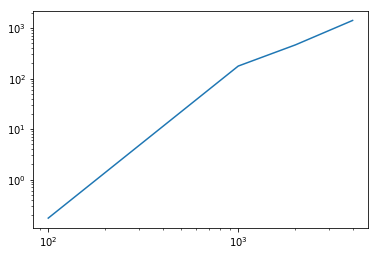

In [5]:
plt.loglog(N_array, runtimes_list)

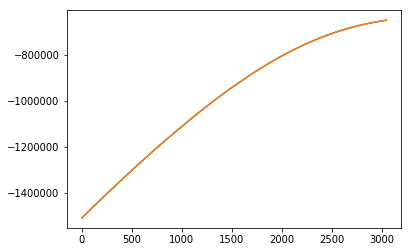

In [6]:
from sklearn.isotonic import IsotonicRegression

ir = IsotonicRegression()

elbos = np.array(elbos)
steps = np.arange(len(elbos))


y_ = ir.fit_transform(steps, elbos)
plt.plot(elbos)
plt.plot(y_)


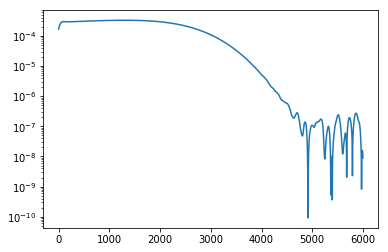

In [7]:
rel_chg = np.abs(np.diff(data)) / np.abs(data[1:])
plt.semilogy(rel_chg)

In [8]:
np.where(rel_chg < 1e-4)[0][0] == len(elbos) - 1

True

In [9]:
runtimes_list

[0.17250823974609375,
 176.41844081878662,
 463.50796723365784,
 1411.1103212833405]

In [10]:
scipy.io.savemat("runtimes_python.mat", {'N_array': N_array, 'runtimes': runtimes_list})
help(scipy.io.savemat)

Help on function savemat in module scipy.io.matlab.mio:

savemat(file_name, mdict, appendmat=True, format='5', long_field_names=False, do_compression=False, oned_as='row')
    Save a dictionary of names and arrays into a MATLAB-style .mat file.
    
    This saves the array objects in the given dictionary to a MATLAB-
    style .mat file.
    
    Parameters
    ----------
    file_name : str or file-like object
        Name of the .mat file (.mat extension not needed if ``appendmat ==
        True``).
        Can also pass open file_like object.
    mdict : dict
        Dictionary from which to save matfile variables.
    appendmat : bool, optional
        True (the default) to append the .mat extension to the end of the
        given filename, if not already present.
    format : {'5', '4'}, string, optional
        '5' (the default) for MATLAB 5 and up (to 7.2),
        '4' for MATLAB 4 .mat files.
    long_field_names : bool, optional
        False (the default) - maximum field nam